---
# **LAB 3 - CUDA Execution Model**
---

# ▶️ CUDA tools...

In [1]:
!nvidia-smi

Wed Jan 21 10:49:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np
import numba
from numba import cuda
import warnings
warnings.filterwarnings("ignore")

print(np.__version__)
print(numba.__version__)

cuda.detect()



2.0.2
0.60.0
Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-b65bf531-3727-0e5c-eb91-e9d7d93167bd
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [3]:
# Suppress Numba deprecation and performance warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

# ✅ Parallel Reduction

In [4]:
import numpy as np
from numba import cuda
import time

from numba import cuda

@cuda.jit
def blockParReduce(array_in, array_out, n):
    tid = cuda.threadIdx.x
    idx = cuda.blockIdx.x * cuda.blockDim.x + tid

    # boundary check (recommended)
    if idx >= n:
        return

    # "local pointer" to this block's segment (array_off)
    base = cuda.blockIdx.x * cuda.blockDim.x

    # in-place reduction in global memory (stride doubles each step)
    stride = 1
    while stride < cuda.blockDim.x:
        if (tid % (2 * stride)) == 0:
            array_in[base + tid] += array_in[base + tid + stride]
        cuda.syncthreads()
        stride *= 2

    # write one result per block (optional, matches common reduction pattern)
    if tid == 0:
        array_out[cuda.blockIdx.x] = array_in[base]

# ----------------------------
# host-side usage
# ----------------------------
blockSize = 1024;               # block dim 1D
numBlock = 1024*1024            # grid dim 1D
n = blockSize * numBlock;       # array dim

# prepare data
a = np.ones(n, dtype=np.int32)
a_d = cuda.to_device(a)
b_d = cuda.device_array(numBlock, dtype=np.int32)

# verify numpy sum time
tic = time.time()
a.sum()
toc = time.time()
print("Numpy sum result:", a.sum())
print(f"Numpy sum time: {toc - tic:.4f} seconds")

# launch kernel
t0 = time.perf_counter()
blockParReduce[numBlock, blockSize](a_d, b_d, n)
cuda.synchronize()
t1 = time.perf_counter()
print(f"Kernel execution time: {t1 - t0:.4f} seconds")
print("speedup over numpy:", (toc - tic) / (t1 - t0))

# copy result back to host
b = b_d.copy_to_host()
print("Final sum:", b.sum())


Numpy sum result: 1073741824
Numpy sum time: 0.6655 seconds
Kernel execution time: 1.7099 seconds
speedup over numpy: 0.38917476209131036
Final sum: 1073741824


## ↘️ TODO...

**Background: Divergence in Reduction**

-   Problem:
    -   threads in the same warp take different paths
    -   warps execute both paths (masked execution)
    -   performance drops
-   Goal:
    -   restructure indexing so the condition is based on a contiguous range of thread IDs

- Divergence-Avoiding Idea

    -  Instead of checking tid % (2\*stride) == 0, compute a new local index:
    $$
    index = 2 \cdot stride \cdot tid
    $$

    -   Then only threads with:
    $$
    index < blockDim.x
    $$


-   Implement the No-Divergence Reduction Loop

-   Use:

    -   `stride = 1, 2, 4, ...`
    -   `index = 2 * stride * tid`
    -   update: `in_arr[base + index] += in_arr[base + index + stride]`

Template:

```{python}
@cuda.jit
def blockParReduce_no_div(in_arr, out_arr, n):
    pass
```

# ✅ Image histogram

In [19]:
!mkdir -p images
!wget -P images https://raw.githubusercontent.com/francodesource/GPUComputing/refs/heads/main/images/dog.bmp

--2026-01-21 11:21:52--  https://raw.githubusercontent.com/francodesource/GPUComputing/refs/heads/main/images/dog.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1609782 (1.5M) [image/bmp]
Saving to: ‘images/dog.bmp’

dog.bmp             100%[===================>]   1.54M  --.-KB/s    in 0.04s   

2026-01-21 11:21:52 (43.7 MB/s) - ‘images/dog.bmp’ saved [1609782/1609782]



In [25]:
!ls /content/images

dog.bmp


Image size: 1024 x 524 x 3


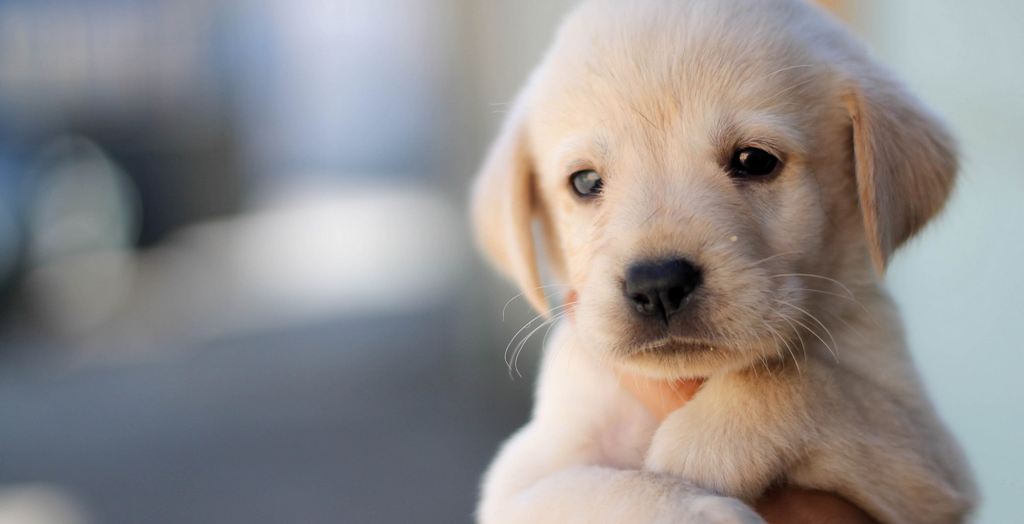

In [43]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
        
img = Image.open("/content/images/dog.bmp") # load image
img_mat = np.array(img).astype(np.uint8) # convert to numpy array
H, W, C = img_mat.shape
print(f"Image size: {W} x {H} x {C}")
img

## ↘️ TODO...

**Problem Description**

-   Given an RGB image `image` of shape: $(H, W, 3)$

-   compute a histogram such that:

    -   `histogram[0, i]` = num pixels with **red value** `i`
    -   `histogram[1, i]` = num pixels with **green value** `i`
    -   `histogram[2, i]` = num pixels with **blue value** `i`

-   Each color channel has **256 bins**

🔹 **CPU Reference Function**

-   CPU helper function that computes a frequency histogram for a 1D array:

``` python
def array_freq(arr):
    h = np.zeros(256, dtype=np.int32)
    for e in arr:
        h[e] += 1
    return h
```

🔹 **CUDA Kernel Requirements**

1.  Uses a 2D grid and 2D block
2.  Maps each thread to one pixel $(y, x)$
3.  Reads the pixel’s RGB values
4.  Updates the histogram using atomic additions
5.  Avoids out-of-bounds accesses

``` python
from numba import cuda

@cuda.jit
def histGPU(image, histogram):
    """
    image: uint8 array of shape (H, W, 3)
    histogram: int32 array of shape (3, 256)
    """
    # TODO
    
```

In [27]:
# CPU reference function
def array_freq(arr):
    h = np.zeros(256, dtype=np.int32)
    for e in arr:
        h[e] += 1
    return h

sequential histogram building time:  0.0130093098 ms
[ 59  62  68  66  69  77  80  96 100 108 112 118 108 121 117 119 121 122
 125 125 129 134 135 145 150 154 151 172 162 188 202 210 210 224 243 253
 261 268 269 275 274 284 289 285 291 294 298 288 291 306 313 299 314 308
 313 318 316 318 322 324 322 340 337 335 341 345 346 360 352 353 365 363
 372 375 394 406 416 409 419 417 421 427 428 429 428 430 434 434 435 431
 433 435 439 438 441 441 441 445 448 445 449 447 451 448 450 450 455 458
 455 457 461 461 463 465 467 474 476 479 485 482 491 495 507 511 509 514
 508 522 522 523 524 523 524 522 523 523 523 524 524 523 524 524 522 521
 522 523 520 521 522 520 522 524 520 523 522 522 523 523 523 521 519 522
 519 522 519 517 520 519 523 516 520 518 522 521 521 522 523 524 523 522
 524 523 522 522 517 521 519 520 518 522 518 522 521 521 523 524 524 524
 524 524 524 524 524 523 524 523 523 522 524 521 519 519 519 520 521 519
 522 522 520 520 519 520 521 519 513 516 508 505 506 513 516 510 506 50

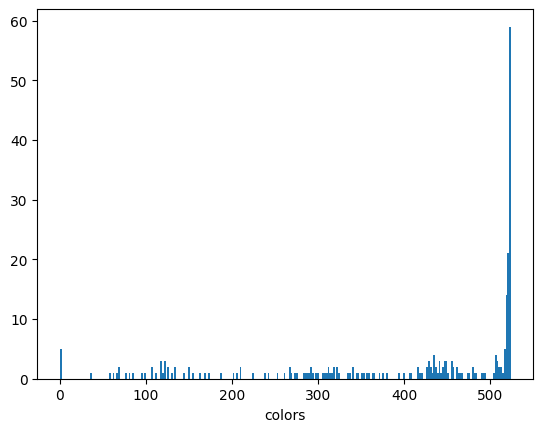

In [ ]:
from time import time
import matplotlib.pyplot as plt

tic = time()
hist = array_freq(img_mat)
toc = time()
print(f'sequential histogram building time: {toc - tic : .10f} ms')
plt.hist(hist, bins=256)
plt.xlabel('colors')
plt.show()

In [48]:
# CUDA kerel

@cuda.jit
def histGPU(image, histogram):
    H, W = image.shape

    y, x = cuda.grid(2)
    # boundary check
    if y >= H or x >= W:
        return
    
    R = image[x, y, 0]
    G = image[x, y, 1]
    B = image[x, y, 2]
    
    cuda.atomic.add(histogram, (0, R), 1)
    cuda.atomic.add(histogram, (1, G), 1)
    cuda.atomic.add(histogram, (2, B), 1)

    

In [50]:
h_hist = np.zeros((3 , 256), dtype=np.int32)
d_hist = cuda.device_array_like(h_hist)

block_size = 32
blocks = (block_size, block_size)
grid = ((W + block_size - 1)// block_size,(H + block_size - 1) // block_size) 

histGPU[grid, blocks](img_mat, d_hist)
cuda.synchronize()
h_hist = d_hist.copy_to_device()
plt.hist(h_hist)
plt.show()

TypingError: Failed in cuda mode pipeline (step: nopython frontend)
('wrong tuple length for $6load_attr.1: ', 'expected 2, got 3')
During: typing of exhaust iter at /tmp/ipython-input-2809615236.py (5)

File "../tmp/ipython-input-2809615236.py", line 5:
<source missing, REPL/exec in use?>
